In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
##Извлечем информацию из файла

dtrain = pd.read_csv('/home/volkov/hard_mnist/hard_train.txt', header = None, sep = '\\s+')
dlabels = pd.read_csv('/home/volkov/hard_mnist/hard_train_labels.txt', header = None, sep = '\\s+')

In [50]:
X_train = np.array(dtrain[:10000])
y_train = np.array(dlabels[:10000])

X_test = np.array(dtrain[10000:11000])
y_test = np.array(dlabels[10000:11000])

Ниже напишем функцию, которая принимает множество объектов признаков, а так же количество компонент, на которое необходимо спроецировать пространство признаков. В случае, если в вызове функции указан путь файла куда нужно сохранить результат, тогда он туда и сохраняется, иначе возвращается из функции.

In [2]:
def t_SNE_algorithm(data_set, n_components, file_path=None):
    RS = 20150101
    tsne_result = TSNE(random_state=RS, n_components=n_components).fit_transform(data_set)
    if file_path: pd.DataFrame(tsne_result).to_csv(file_path, sep=' ', index=False, header=False, mode='a')
    return tsne_result

Запустим t-SNE на 2 компонентах. А на вход подадим первые 10000 объектов обучающей выборки. Затем отобразим получившееся множество на графике.

In [ ]:
file_path = "t-SNE_output/t_SNE_10000.txt"
t_SNE_algorithm(X_train, n_components=2, file_path=file_path)

Как видим объекты кучкуются в отдельные группы и между ними отчетлива видна граница. Сравнивая с графиком, получившимся при проецировании с помощью PCA, нетрудно заметить, что t-SNE работает гораздо лучше. И Это безусловно должно отразиться на классификации. Что мы, вероятно, будем дальше наблюдать. И, возможно, после сжатия с помощью t-SNE мы получим лучшее качество классификации, чем в исходном пространстве. Так как t-SNE может погасить шумы.

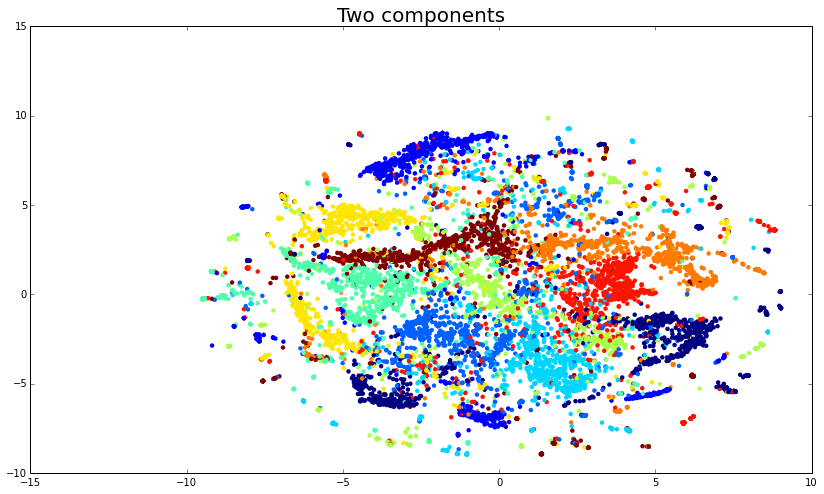

In [86]:
t_SNE_result = np.array(pd.read_csv('t-SNE_output/t_SNE_10000.txt', header = None, sep = '\\s+'))
plt.figure(figsize=(14,8))
plt.title("Two components", fontsize=20)

plt.scatter(t_SNE_result[:, 0], t_SNE_result[:, 1], c=y_train, linewidths=0)
plt.show()

Запустим проецирование на k из {1, 2, 3, 4, 5} разных компонент на первой выборке. 

In [ ]:
for n_components in range(1, 6):
    data_set = np.array(dtrain[:11000])
    file_path = "t-SNE_output{}/t_SNE_data.txt".format(n_components)
    t_SNE_algorithm(data_set, n_components, file_path=file_path)

Далее запускаем KNN на всех сжатых выборках на k из {1, 2, 3, ..., 20} соседях.

In [3]:
def knn_algorithm(X_train, y_train, X_test, y_test, **kargs):
    start = time.time()
    model = KNeighborsClassifier(**kargs)
    model.fit(X_train, y_train)
    fraction_misclassifications = zero_one_loss(y_test, model.predict(X_test))
    end = time.time()
    return(fraction_misclassifications, end-start)

In [69]:
for n_components in range(1, 6):
    f = pd.read_csv('t-SNE_output{}/t_SNE_data.txt'.format(n_components), header = None, sep = '\\s+')
    X_t_SNE_train = f[:10000][:]
    X_t_SNE_test = f[10000:][:]
    result = []
    for neighbors in range(1, 21):
        error_with_time = knn_algorithm(X_t_SNE_train, y_train, X_t_SNE_test, y_test, n_neighbors=neighbors, 
                                        algorithm='brute')
        result.append(error_with_time)
    pd.DataFrame(result).to_csv('t-SNE_output{}/knn_t_SNE.txt'.format(n_components), sep=' ', index=False,
                                header=False, mode='a')

Чтобы визуализировать полученные данные. Проедалем все то, что мы делали в случае с PCA.

In [14]:
def time_accuracy_matrix_plot(accuracy, time):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 8))
    ax1.imshow(accuracy, interpolation='none')
    ax1.set_title('Accuracy', fontsize=15)
    ax2.imshow(time, interpolation='none')
    ax2.set_title('Time', fontsize=15)
    return(plt)

По графику Accuracy видно резкое ухудшение качества классификации при проецировании на более чем 3 компоненты. Данное поведение объясняется неустойчивостью метода при большем чем три размерности пространства, так как t-SNE базируется на распределении Стьюдента, хвосты которого в многомерных пространствах утежеляются, а это в свою очередь отражается на вероятностях, искажение которых напрямую влияет на степень взаимосвязанности объектов.

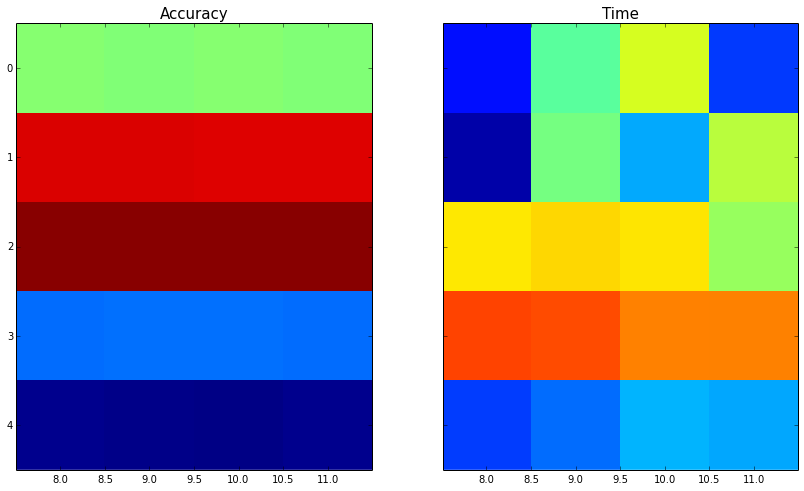

In [87]:
time, accuracy = [], []
for n_components in range(1, 6):
    f = pd.read_csv('t-SNE_output{}/knn_t_SNE.txt'.format(n_components), header = None, sep = '\\s+')
    accuracy.append(1 - np.array(f[:][0]))
    time.append(np.array(f[:][1]))
matrix_plot = time_accuracy_matrix_plot(accuracy, time)
matrix_plot.show()

Чтобы уменьшить влияние шума проделаем все то, что мы делали выше с разными разбиениями исходной выборки.

In [ ]:
step = 10000
data_set_size = 1000

for data_set_number in range(3, 4):
    data_set = np.array(dtrain[step*data_set_number:step*(data_set_number+1)+data_set_size])
    for n_components in range(1, 3):
        file_path = "t-SNE_output{}/t_SNE_data{}.txt".format(n_components, data_set_number)
        t_SNE_algorithm(data_set, n_components, file_path=file_path)

Пропускаем новые данные через KNN.

In [8]:
step = 10000
test_size = 1000
for data_set_number in range(1, 4):
    y_train = np.array(dlabels[step*data_set_number:step*(data_set_number+1)])
    y_test = np.array(dlabels[step*(data_set_number+1):step*(data_set_number+1)+test_size])
    for n_components in range(1, 6):
        f = pd.read_csv('t-SNE_output{}/t_SNE_data{}.txt'.format(n_components, data_set_number), header = None, 
                        sep = '\\s+')
        X_t_SNE_train = f[:10000][:]
        X_t_SNE_test = f[10000:][:]
        result = []
        for neighbors in range(1, 21):
            error_with_time = knn_algorithm(X_t_SNE_train, y_train, X_t_SNE_test, y_test, n_neighbors=neighbors, 
                                            algorithm='brute')
            result.append(error_with_time)
        pd.DataFrame(result).to_csv('t-SNE_output{}/knn_t_SNE{}.txt'.format(n_components, data_set_number), sep=' ',
                                    index=False, header=False, mode='a')

Усредняем полученные результаты.

In [10]:
for n_components in range(1, 6):
    average = np.array(pd.read_csv('t-SNE_output{}/knn_t_SNE{}.txt'.format(n_components, 1),
                                   header = None, sep = '\\s+'))
    for data_set_number in range(1, 4):
        average += np.array(pd.read_csv('t-SNE_output{}/knn_t_SNE{}.txt'.format(n_components, data_set_number),
                                 header = None, sep = '\\s+'))
    pd.DataFrame(average/5).to_csv('t_SNE_output_average/knn_t_SNE_average{}.txt'.format(n_components), sep=' ',
                                    index=False, header=False, mode='a')

И визуализируем матрицу.

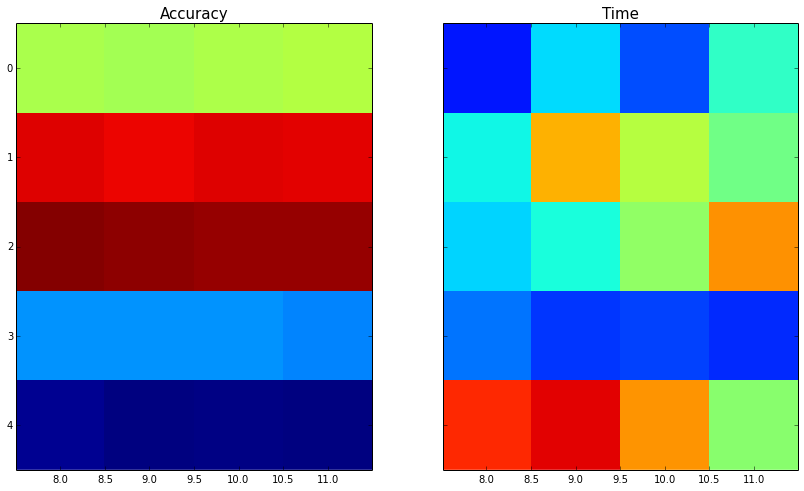

In [15]:
time, accuracy = [], []
for n_components in range(1, 6):
    f = pd.read_csv('t_SNE_output_average/knn_t_SNE_average{}.txt'.format(n_components), header = None, sep = '\\s+')
    accuracy.append(1 - np.array(f[:][0]))
    time.append(np.array(f[:][1]))

matrix_plot = time_accuracy_matrix_plot(accuracy, time)
matrix_plot.show()

Допольнительная визуализация. На самом деле после прогонки KNN на сжатых данных, было бы логично визуализировать полученные результаты так, как мы это делали в пунтке 1 данной лабораторной работы. Когда обучали KNN на несжатых данных. И по идее вид кривой не должен сильно отличаться. Но очень интересен тот факт, что при проецировании на более чем 3 компоненты качество классификации стремительно падает к нулю. Это объясняется особенностью распределения Стьюдента(написал выше), которое с одной стороны решает разные проблемы(проблема скученности и оптимизации функции потерь), но с другой стороны доставляет нам неприятности при проецировании на многомерные пространтсва. Таким образом, можно сделать вывод, что оптимально запускать t-SNE при проецировании на 2-3 компоненты.

Кстати говоря, на данном графике можно заметить, что 2NN уже не дает такой большой ошибки, как в пункте 1, данной лабораторной. Это объясняется тем, что граница между классами уже не так засорены, в этом можно убедиться посмотрев на самый первый график в текущем документе. В целом все элементы кучкуются в своих классах и можно отследить линию границы

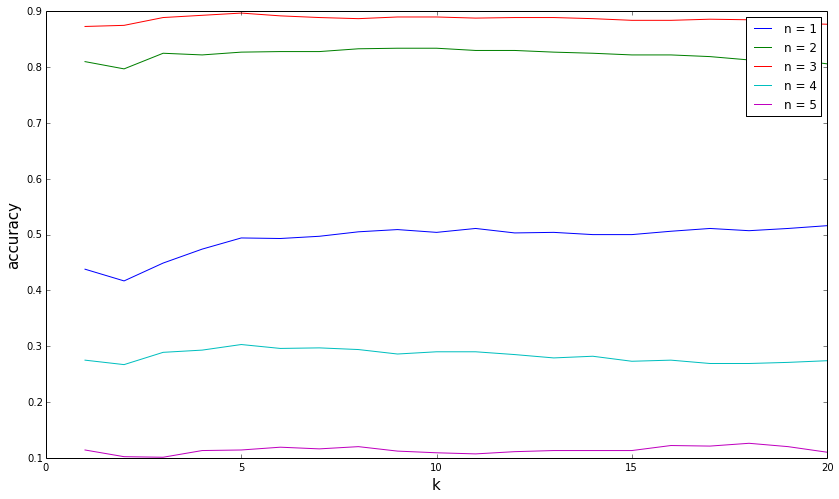

In [80]:
plt.figure(figsize=(14,8))
plt.ylabel("accuracy", fontsize=15)
plt.xlabel("k", fontsize=15)


k = range(1, 21)
for n_components in range(1, 6):
    f = pd.read_csv('t-SNE_output{}/knn_t_SNE.txt'.format(n_components), header = None, sep = '\\s+')
    accuracy = 1 - np.array(f[:][0])
    plt.plot(k, accuracy)
plt.legend(['n = 1', 'n = 2', 'n = 3', 'n = 4', 'n = 5'])    
plt.show()